PLAN DU PROJET : 

- trouver les équations et les coder

- les réosudre de différentes manieres : 

1. Euler

2. Runge-Kunta q = 2

3. Runge-Kunta q = 4

- Comparer avec les solutions du rapport

- Étudier les constantes de stabilité dans chaque cas

- Étudier la consistance des solutions dans chaque cas 

- Conclure quant à la fiabilité des solutions données

LES DIFFÉRENTES VARIABLES QUI NOUS INTÉRESSENT ET DONT ON DOIT TROUVER L'ÉVOLUTION

- ATMOSPHERE

- CARBONATE ROCK

- DEEP OCEAN

- FOSSIL FUEL CABRONATE

- PLANT

- SOIL

- OCEAN SURFACE

- VEG LAND AREA



# I. DIFFÉRENTES ÉQUATIONS RÉGISSANT LE CYCLE DU CARBONE

On note $X:\mathbb{R} \mapsto \mathbb{R}^n$ la fonction qui renvoie le vecteur qui regroupe l'ensemble de ces données à un instant donné.

Il nous est donné, dans le code Python fourni, une fonction (qu'on notera $f$ pour être en adéquation avec le cours) qui calcule la dérivée $X'(t)$ en fonction de la valeur de $t$ et de $X(t)$. On a donc le problème suivant:

$$\forall t \in \mathbb{R}_{+}, X'(t) = f(t, X'(t))$$

$$ X(0) = X_0 $$

Le projet étudiera plusieurs méthodes qui cherchent à résoudre ce problème et à comparer les résolutions numériques avec celles du site web.

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Initial conditions
Atmosphere_Initial = 750
CarbonateRock_Initial = 100000000
DeepOcean_Initial = 38000
FossilFuel_Initial = 7500
Plant_Initial = 560
Soil_Initial = 1500
SurfaceOcean_Initial = 890
VegLandArea_percent_Initial = 100

x0 = np.array([Atmosphere_Initial,
               CarbonateRock_Initial,
               DeepOcean_Initial,
               FossilFuel_Initial,
               Plant_Initial,
               Soil_Initial,
               SurfaceOcean_Initial,
               VegLandArea_percent_Initial
               ])

# Constants
Alk = 2.222446077610055
Kao = .278
SurfOcVol = .0362
Deforestation = 0

# Helper functions
def AtmCO2(Atmosphere):
    return Atmosphere * (280/Atmosphere_Initial)
def GlobalTemp(AtmCO2):
    return 15 + ((AtmCO2-280) * .01)
def CO2Effect(AtmCO2):
    return 1.5 * ((AtmCO2) - 40) / ((AtmCO2) + 80)
def WaterTemp(GlobalTemp):
    return 273+GlobalTemp
def TempEffect(GlobalTemp):
    return ((60 - GlobalTemp) * (GlobalTemp + 15)) / (((60 + 15) / 2) ** (2))/.96
def SurfCConc(SurfaceOcean):
    return (SurfaceOcean/12000)/SurfOcVol
def Kcarb(WaterTemp):
    return .000575+(.000006*(WaterTemp-278))
def KCO2(WaterTemp):
    return .035+(.0019*(WaterTemp-278))
def HCO3(Kcarb, SurfCConc):
    return(SurfCConc-(np.sqrt(SurfCConc**2-Alk*(2*SurfCConc-Alk)*(1-4*Kcarb))))/(1-4*Kcarb)
def CO3(HCO3):
    return (Alk-HCO3)/2
def pCO2Oc(KCO2, HCO3, CO3):
    return 280*KCO2*(HCO3**2/CO3)


# Fossil fuels
FossFuelData = np.array([[50.0, 0.00], [75.0, 0.30], [100.0, 0.60], [125.0, 1.35], [150.0, 2.85], [175.0, 4.95], [200.0, 7.20], [225.0, 10.05], [250.0, 14.85], [275.0, 20.70], [300.0, 30.00]])
def FossilFuelsCombustion(t):
    i = 0
    if t >= FossFuelData[-1,0]:
        return FossFuelData[-1,1]
    while i + 1 < len(FossFuelData) and t >= FossFuelData[i,0]:
        i = i + 1
    if i == 0:
        return FossFuelData[0,1]
    else:
        return FossFuelData[i-1,1] + (t - FossFuelData[i-1,0]) / (FossFuelData[i,0] - FossFuelData[i-1,0]) * (FossFuelData[i,1] - FossFuelData[i-1,1])

def derivative(x, t):
    Atmosphere = x[0]
    CarbonateRock = x[1]
    DeepOcean = x[2]
    FossilFuelCarbon = x[3]
    Plants = x[4]
    Soils = x[5]
    SurfaceOcean = x[6]
    VegLandArea_percent = x[7]

    PlantResp = (Plants * (55/Plant_Initial)) + Deforestation/2
    Litterfall = (Plants* (55/Plant_Initial))+(Deforestation/2)
    SoilResp = Soils * (55/Soil_Initial)
    Volcanoes = 0.1
    AtmCO2_ = AtmCO2(Atmosphere)
    GlobalTemp_ = GlobalTemp(AtmCO2_)
    WaterTemp_ = WaterTemp(GlobalTemp_)
    Photosynthesis = 110 * CO2Effect(AtmCO2_) * (VegLandArea_percent/100) * TempEffect(GlobalTemp_)
    HCO3_ = HCO3(Kcarb(WaterTemp_), SurfCConc(SurfaceOcean))
    pCO2Oc_ = pCO2Oc(KCO2(WaterTemp_), HCO3_, CO3(HCO3_))
    AtmOcExchange = Kao*(AtmCO2_-pCO2Oc_)
    if x[3] > 0:
        FossilFuelsCombustion_ = FossilFuelsCombustion(t)
    else:
        FossilFuelsCombustion_ = 0
    dAtmosphere_dt = (PlantResp + SoilResp + Volcanoes + FossilFuelsCombustion_
                          - Photosynthesis - AtmOcExchange)

    Sedimentation = DeepOcean * (0.1/DeepOcean_Initial)
    dCarbonateRock_dt = Sedimentation - Volcanoes

    Downwelling = SurfaceOcean*(90.1/SurfaceOcean_Initial)
    Upwelling = DeepOcean * (90/DeepOcean_Initial)
    dDeepOcean_dt= Downwelling - Sedimentation - Upwelling

    dFossilFuelCarbon_dt = - FossilFuelsCombustion_

    dPlants_dt = Photosynthesis - PlantResp - Litterfall

    dSoils_dt = Litterfall - SoilResp

    dSurfaceOcean_dt = Upwelling + AtmOcExchange - Downwelling

    Development = (Deforestation/Plant_Initial * 0.2) * 100
    dVegLandArea_percent_dt = - Development

    derivative = np.array([
        dAtmosphere_dt,
        dCarbonateRock_dt,
        dDeepOcean_dt,
        dFossilFuelCarbon_dt,
        dPlants_dt,
        dSoils_dt,
        dSurfaceOcean_dt,
        dVegLandArea_percent_dt
        ])

    return derivative



# II. RÉSOLUTION AVEC EULER

<ipython-input-50-e20dae3a16d0>:48: RuntimeWarning: invalid value encountered in sqrt
  return(SurfCConc-(np.sqrt(SurfCConc**2-Alk*(2*SurfCConc-Alk)*(1-4*Kcarb))))/(1-4*Kcarb)
No handles with labels found to put in legend.


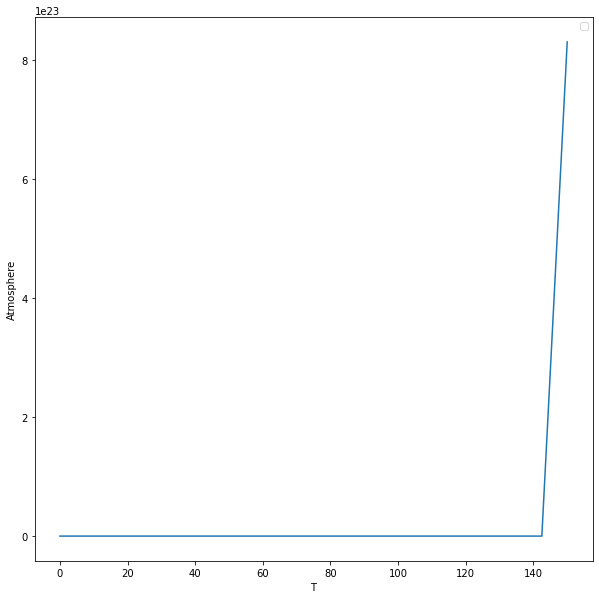

No handles with labels found to put in legend.


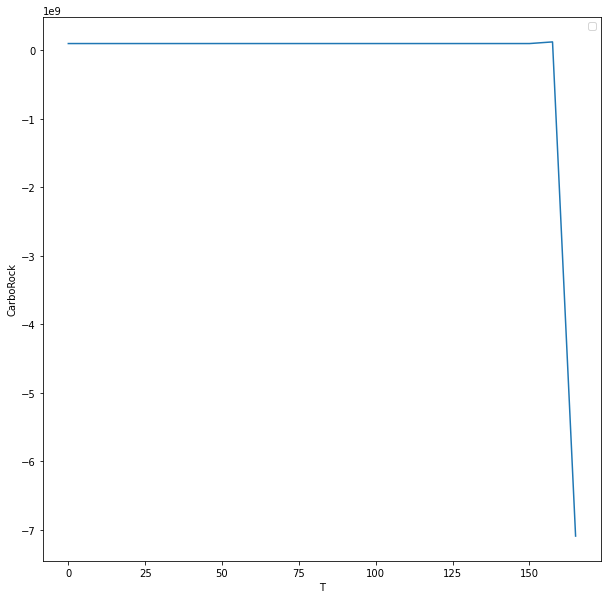

No handles with labels found to put in legend.


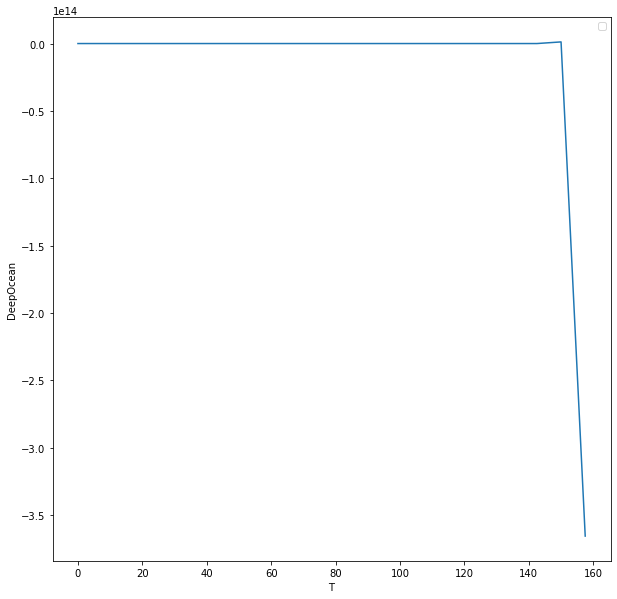

No handles with labels found to put in legend.


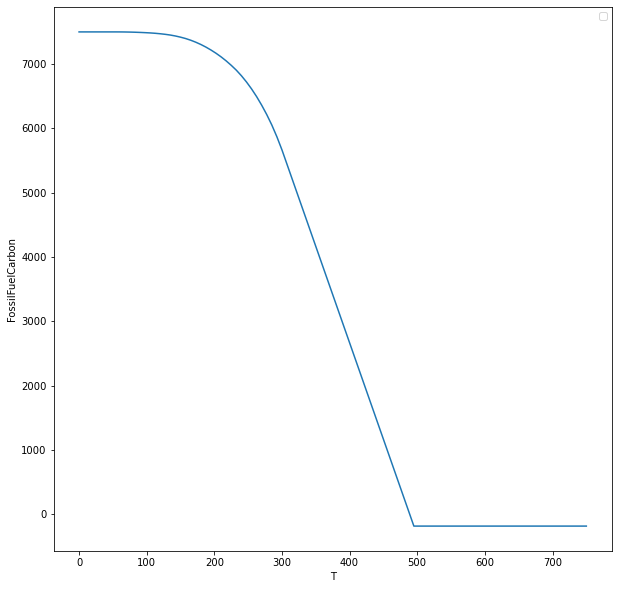

No handles with labels found to put in legend.


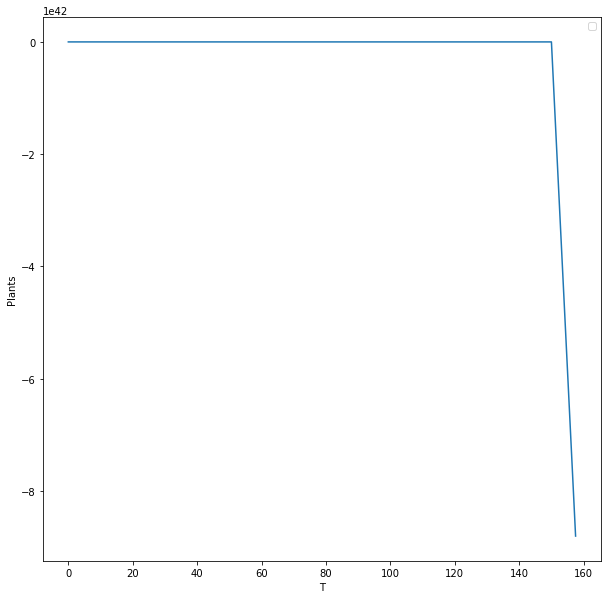

No handles with labels found to put in legend.


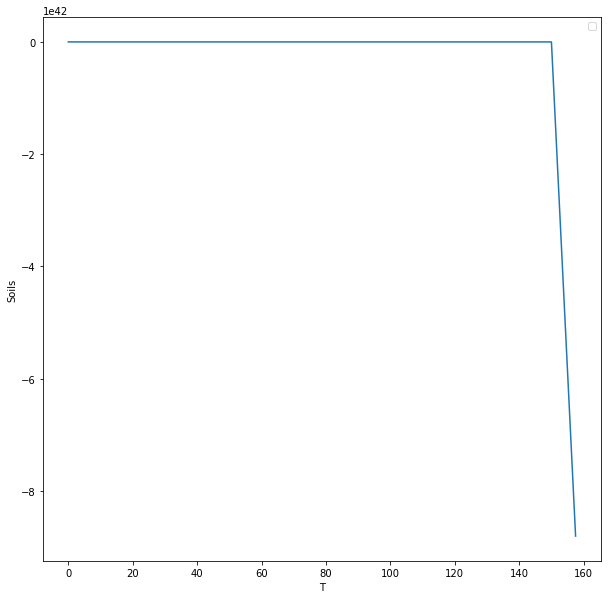

No handles with labels found to put in legend.


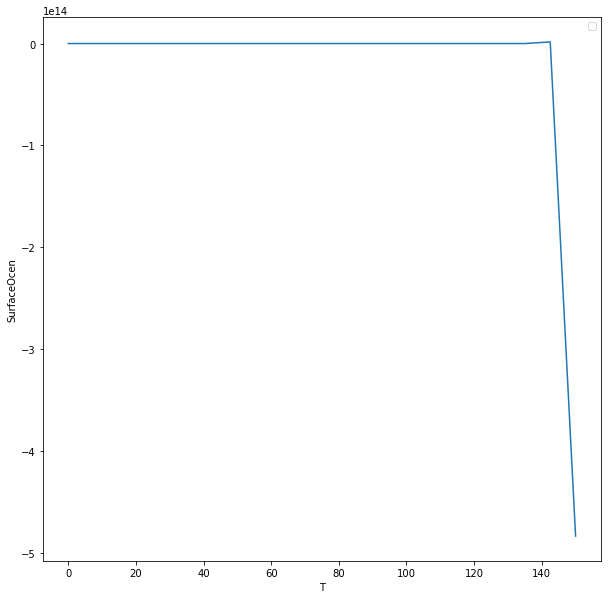

No handles with labels found to put in legend.


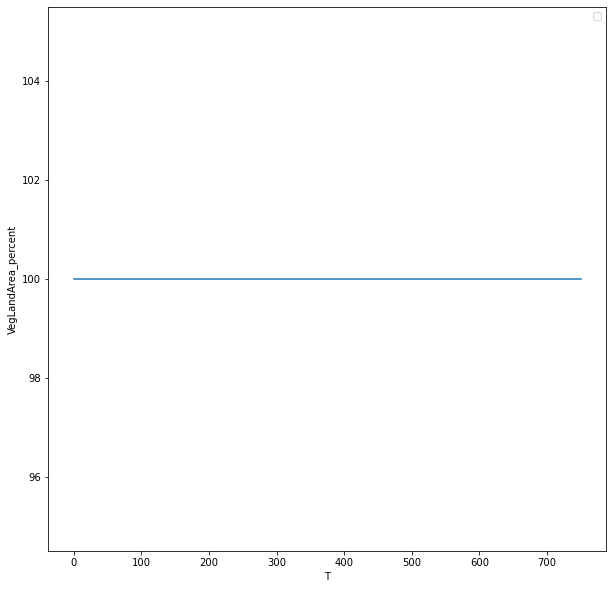

In [54]:
#POUR LE SOILS, derivative[5], x[5], x0[5]
#dSoils_dt = Litterfall - Soils * (55/Soil_Initial)

# Atmosphere = x[0]
#CarbonateRock = x[1]
#DeepOcean = x[2]
#FossilFuelCarbon = x[3]
#Plants = x[4]
#Soils = x[5]
#SurfaceOcean = x[6]
#VegLandArea_percent = x[7]

def euler(F, t0,tf,y0, n): # y’=F(y,t) 
    h = (tf-t0)/n
    y = y0
    t = t0
    Y = [y0]
    T = [t0]
    for k in range(n): 
        y = y + h * F(y,t)
        t=t+h 
        Y.append(y) 
        T.append(t)
    return T,Y

#le y equivaut au vecteur x et au début y0 = x0 en vecteur, donc F c'est la fonction dérivative

T,Y = euler(derivative,0,750,x0,100)

def Atmosphere():
    Atmo = []
    for i in range(101):
        Atmo.append(Y[i][0])
    return Atmo

def CarboRock():
    L=[]
    for i in range(101):
        L.append(Y[i][1])
    return L

DeepOcean = [Y[i][2] for i in range(101)]
FossilFuelCarbon = [Y[i][3] for i in range(101)]
Plants = [Y[i][4] for i in range(101)]
Soils = [Y[i][4] for i in range(101)]
SurfaceOcean = [Y[i][6] for i in range(101)]
VegLandArea_percent = [Y[i][7] for i in range(101)]
Atmosphere1=Atmosphere()
CarbonateRock = CarboRock()

plt.figure(figsize=(10,10))
plt.plot(T,Atmosphere1)
plt.xlabel('T')
plt.ylabel('Atmosphere')
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
plt.plot(T,CarbonateRock)
plt.xlabel('T')
plt.ylabel('CarboRock')
plt.legend()
plt.show()


plt.figure(figsize=(10,10))
plt.plot(T,DeepOcean)
plt.xlabel('T')
plt.ylabel('DeepOcean')
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
plt.plot(T,FossilFuelCarbon)
plt.xlabel('T')
plt.ylabel('FossilFuelCarbon')
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
plt.plot(T,Plants)
plt.xlabel('T')
plt.ylabel('Plants')
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
plt.plot(T,Soils)
plt.xlabel('T')
plt.ylabel('Soils')
plt.legend()
plt.show()


plt.figure(figsize=(10,10))
plt.plot(T,SurfaceOcean)
plt.xlabel('T')
plt.ylabel('SurfaceOcen')
plt.legend()
plt.show()

plt.figure(figsize=(10,10))
plt.plot(T,VegLandArea_percent)
plt.xlabel('T')
plt.ylabel('VegLandArea_percent')
plt.legend()
plt.show()

# III. RÉSOLUTION AVEC RUNGE-KUTTA

## a) Avec q = 2

## a) Avec q = 4